<a href="https://colab.research.google.com/github/PnZheng/DeepLearning/blob/main/CNN/transfer_learning_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlexNet

AlexNet是LeNet的后继者，它在架构上有了增加到了8层（5层卷积层，3层全连接层），并且模型的参数也从六万多个增加到了五六十万个。其外在AlexNet中，训练的数据集为ImageNet，高达100多GB，而不是之前的MNIST数据集。

为了能够更快的复现该模型，我们接下来将使用以及预训练好的模型来进行使用。

我们引入了matplotlib来展示训练时的图像
并且手工设置了随机种子以确保实验的可重复性

In [32]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
torch.manual_seed(0)
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### 数据集信息
- 数据集里分为两类，蜜蜂和蚂蚁，其中有240张的训练图像和150张的验证图像。
- 我们可以从这个链接下载 - https://www.kaggle.com/ajayrana/hymenoptera-data 然后存储在当前的工作目录下
- 为了下载该数据你可能需要在kaggle进行登录，没有的话需要进行账号注册
- 更多关于数据集的信息能够在这里进行查询: https://hymenoptera.elsiklab.missouri.edu/
- 相关数据集也已经下载好在目录可直接使用
- 也可以使用下面的命令进行下载


In [1]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip /content/hymenoptera_data.zip 

'wget' is not recognized as an internal or external command,
operable program or batch file.
unzip:  cannot find or open /content/hymenoptera_data.zip, /content/hymenoptera_data.zip.zip or /content/hymenoptera_data.zip.ZIP.


## 训练数据的数据的归一化和增强变换
-  验证集中只有归一化操作
-  归一化的均值和方差被计算从而作为所有训练集中所有像素通道的均值数据 -- R、G、B通道

In [33]:
ddir = 'hymenoptera_data'
# ddir = '/content/hymenoptera_data'   

data_transformers = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])]),
    'val': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])])}

img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in ['train', 'val']}
dloaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=True, num_workers=2) 
            for k in ['train', 'val']}
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes
print(dloaders)
print(dset_sizes)
print(classes)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x000002414B9EECD0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x000002414B9EEC10>}
{'train': 244, 'val': 153}
['ants', 'bees']


## 定义图片显示的函数


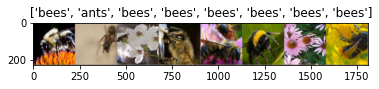

In [34]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

imgs, cls = next(iter(dloaders['train']))
grid = torchvision.utils.make_grid(imgs)
imageshow(grid, text=[classes[c] for c in cls])

## 利用预训练好的模型来训练我们需的模型
#### 模型训练和验证的实现
在这里我们加载一个预训练好的 AlexNet 模型，并在不同于它预训练的ImageNet的图像分类数据集上对其进行微调。
最后，我们将测试微调模型的性能，看看它是否可以从新数据集迁移学习。

根据上面定义好的数据类型，可以来将AlexNet模型网络转换为train/eval模式，并且在每个epoch中都进行两者的训练。

需要注意的是，只有在训练模式下才进行反向传播进行参数更新，因此需要设置一下

最后，将在训练中得到的效果最好的模型参数，并在最后将完整的模型进行保存并返回。

In [35]:
def finetune_model(pretrained_model, loss_func, optim, epochs=10):
    start = time.time()
    model_weights = copy.deepcopy(pretrained_model.state_dict())
    accuracy = 0.0

    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)
        for dset in ['train', 'val']:
            if dset == 'train':
                pretrained_model.train()  # 将模型设为训练模式
            else:
                pretrained_model.eval()   # 将模型设为验证模式

            loss = 0.0
            successes = 0
            # 迭代（培训/验证）数据
            for imgs, tgts in dloaders[dset]:
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optim.zero_grad()
                with torch.set_grad_enabled(dset == 'train'):
                    ops = pretrained_model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)
                    if dset == 'train':
                        loss_curr.backward()
                        optim.step()

                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]
            # 保存模型的参数数据 
            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
                model_weights = copy.deepcopy(pretrained_model.state_dict())
        print()

    time_delta = time.time() - start
    print(f'Training finished in {time_delta // 60}mins {time_delta % 60}secs')
    print(f'Best validation set accuracy: {accuracy}')
    # 加载最好的模型参数权重
    pretrained_model.load_state_dict(model_weights)
    return pretrained_model

## 定义一个函数来实现预测并显示结果、准确率

In [36]:
def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(dvc)
            tgts = tgts.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)
            
            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

## 加载预训练好的AlexNet模型

- 我们可以通过models模块进行加载预训练好的模型。
- 如果无法成功加载，可以先定义好模型，后将文件中的pth文件进行参数加载，如下所示：
    - lenet_cached = LeNet()
    - lenet_cached.load_state_dict(torch.load(model_path))
- 此外，我们能够利用summary模块对函数的输入输出层次进行结构化的显示

In [41]:
model_finetune = models.alexnet(pretrained=True)
print(model_finetune.features)

from torchsummary import summary
summary(model_finetune.to(dvc),input_size=(3, 256, 256))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 6

In [27]:
print(model_finetune.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


由于预训练好的模型实在ImageNet下训练的，该数据集的最后结果为1000个分类类别（如上所示）。

所以我们需要将最后的1000个分类输出修改为2个分类输出-> nn.Linear(4096, len(classes))

并且定义该函数的优化器以及损失函数。这里需要将模型放在GPU中运行。


In [29]:
model_finetune.classifier[6] = nn.Linear(4096, len(classes))
loss_func = nn.CrossEntropyLoss()
optim_finetune = optim.SGD(model_finetune.parameters(), lr=0.0001)

# train (fine-tune) and validate the model
model_finetune = finetune_model(model_finetune.to(dvc), loss_func, optim_finetune, epochs=10)

Epoch number 0/9
train loss in this epoch: 0.658834065570206, accuracy in this epoch: 0.6311475409836066
val loss in this epoch: 0.5777581189972123, accuracy in this epoch: 0.6797385620915033

Epoch number 1/9
train loss in this epoch: 0.5526453197979536, accuracy in this epoch: 0.709016393442623
val loss in this epoch: 0.4818410947431926, accuracy in this epoch: 0.7777777777777778

Epoch number 2/9
train loss in this epoch: 0.4778134168171492, accuracy in this epoch: 0.7827868852459017
val loss in this epoch: 0.4314229000432819, accuracy in this epoch: 0.803921568627451

Epoch number 3/9
train loss in this epoch: 0.44318222608722624, accuracy in this epoch: 0.8278688524590164
val loss in this epoch: 0.39530620271084355, accuracy in this epoch: 0.8300653594771242

Epoch number 4/9
train loss in this epoch: 0.4273624962470571, accuracy in this epoch: 0.7909836065573771
val loss in this epoch: 0.36634763490919975, accuracy in this epoch: 0.8431372549019608

Epoch number 5/9
train loss in

cuda:0


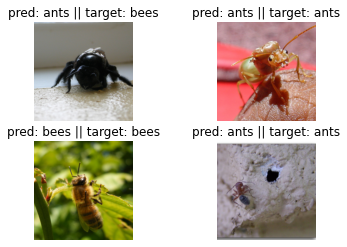

In [31]:
visualize_predictions(model_finetune)

## 练习

- 试着增加迭代周期后，实验得出的结果有什么不同？为什么？